## Libraries

In [164]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

## Evaluate the following models versus a dummy classifier:
    - Decision Tree (CART)
    - k-Nearest Neighbors (KNN)
    - Bagged Decision Trees (BAG)
    - Random Forest (RF)
    - Extra Trees (ET)

In [17]:
# load the dataset
def load_dataset(file_path):
    # load the dataset as a dataframe
    data_df = pd.read_pickle(file_path)
    # split into features and target
    X, y = data_df.drop('halal', axis=1), data_df.halal
    return X, y

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
   # calculate precision-recall curve
   p, r, _ = precision_recall_curve(y_true, probas_pred)
   # calculate area under curve
   return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # BASE
    models.append(DummyClassifier(strategy='constant', constant=1))
    names.append('BASE')
    # CART
    models.append(DecisionTreeClassifier())
    names.append('CART')
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    names.append('KNN')
    # Bagging
    models.append(BaggingClassifier(n_estimators=4))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=4))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=4))
    names.append('ET')
    return models, names

>BASE 0.866 (0.003)
>CART 0.884 (0.021)
>KNN 0.913 (0.020)
>BAG 0.895 (0.022)
>RF 0.898 (0.023)
>ET 0.893 (0.026)


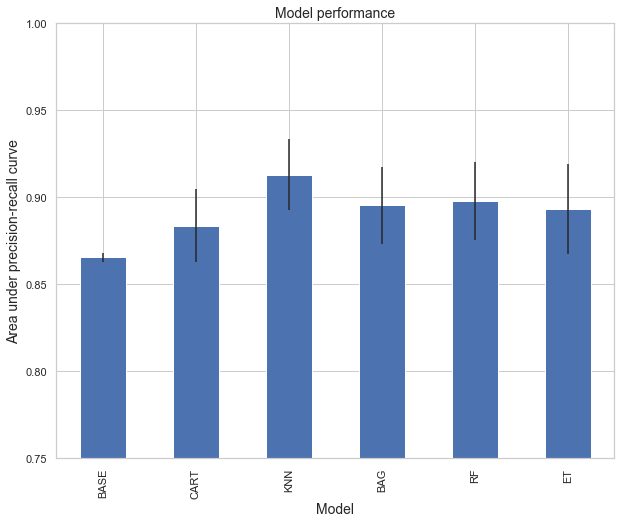

In [183]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/features_draft_1.pkl'
# load the dataset
X, y = load_dataset(file_path)
# define models
models, names = get_models()
# evaluate each model
results = list()
for i, model in enumerate(models):
    # evaluate the model and store results
    scores = evaluate_model(X, y, model)
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plot_df = pd.DataFrame(columns=['models', 'results'])
plot_df['models'] = names
plot_df['results'] = [result.tolist() for result in results]
plot_df['mean'] = plot_df['results'].apply(mean)
plot_df['sd'] = plot_df['results'].apply(std)
ax = plot_df.plot(kind='bar', y='mean', x='models', yerr='sd', legend=False, figsize=(10,8))
ax.set_ylim(0.75,1)
ax.set_title('Model performance', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylabel('Area under precision-recall curve', size=14)
plt.show()

## Evaluate these resampling techniques versus the original dataset:
    - oversample minority class
    - undersample majority class
    - generate synthetic samples

In [129]:
# define resampling method
def split_and_resample(X, y, resampling):
    # setting up testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
    # concatenate our training data back together
    X = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    min_class = X[X.halal==X.halal.value_counts().sort_values().index[0]]
    max_class = X[X.halal==X.halal.value_counts().sort_values().index[1]]
    # oversampling minority
    if resampling == 'oversample':
        new_min_class = resample(min_class, replace=True, n_samples=(len(max_class)))
        upsampled = pd.concat([max_class, new_min_class])
        return upsampled.drop('halal', axis=1), upsampled.halal, X_test, y_test
    elif resampling == 'undersample':
        new_max_class = resample(max_class, replace=True, n_samples=(len(min_class)))
        downsampled = pd.concat([new_max_class, min_class])
        return downsampled.drop('halal', axis=1), downsampled.halal, X_test, y_test
    elif resampling == 'SMOTE':
        X_train, y_train = SMOTE().fit_sample(X_train, y_train)
        return X_train, y_train, X_test, y_test

>oversample 0.921 (0.018)
>undersample 0.756 (0.056)
>SMOTE 0.773 (0.037)


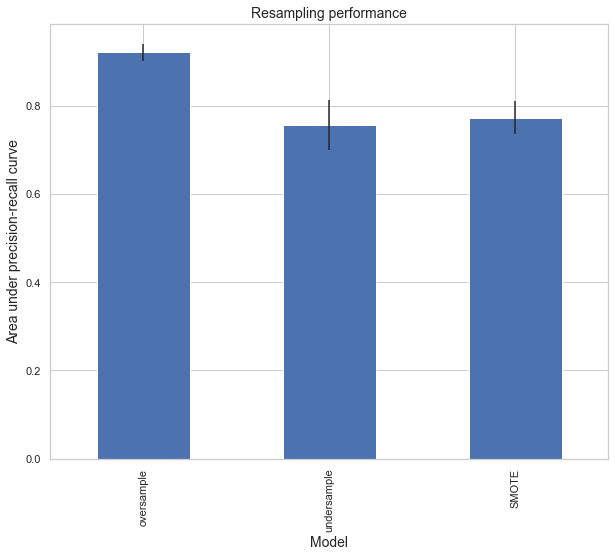

In [125]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/features_draft_1.pkl'
# load the dataset
X, y = load_dataset(file_path)
# define resampling
resampling = ['oversample', 'undersample', 'SMOTE']
results = list()
# evaluate each resampling method using CART
model = DecisionTreeClassifier()
for method in resampling:
    # split and resample data
    X_train, y_train, X_test, y_test = split_and_resample(X, y, method)
    # evalue using resampled data
    scores = evaluate_model(X_train, y_train, model)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (method, mean(scores), std(scores)))
# plot the results
plot_df = pd.DataFrame(columns=['resampling', 'results'])
plot_df['resampling'] = resampling
plot_df['results'] = [result.tolist() for result in results]
plot_df['mean'] = plot_df['results'].apply(mean)
plot_df['sd'] = plot_df['results'].apply(std)
ax = plot_df.plot(kind='bar', y='mean', x='resampling', yerr='sd', legend=False, figsize=(10,8))
ax.set_title('Resampling performance', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylabel('Area under precision-recall curve', size=14)
plt.show()

## Tune CART max_depth:

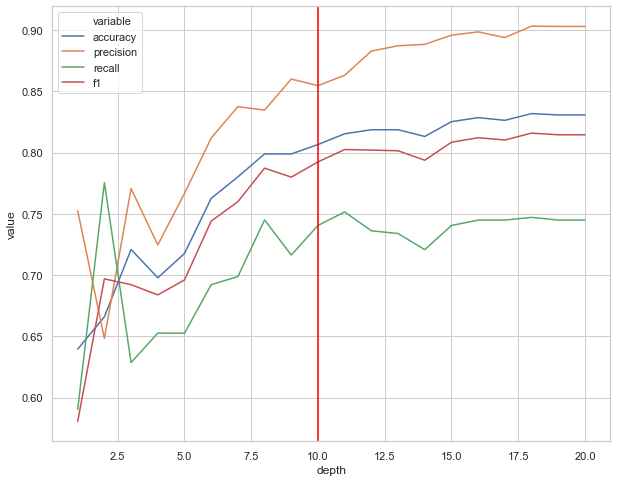

In [171]:
# load dataset
X, y = load_dataset(file_path)

# oversample non_halal class
X_train, y_train, X_test, y_test = split_and_resample(X, y, 'oversample')

# initialize CART with different depths
depths = range(1, 21)
plot_df = pd.DataFrame(columns=['depth', 'accuracy', 'precision', 'recall', 'f1'], dtype=float)
plot_df['depth'] = depths
scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'}

for i, depth in plot_df['depth'].iteritems(): 
    model = DecisionTreeClassifier(max_depth=depth)
    # train model and collect metrics
    cv_scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = 3, n_jobs = -1)
    plot_df.loc[i, 'accuracy'] = cv_scores['test_acc'].mean()
    plot_df.loc[i, 'precision'] = cv_scores['test_prec'].mean()
    plot_df.loc[i, 'recall'] = cv_scores['test_rec'].mean()
    plot_df.loc[i, 'f1'] = cv_scores['test_f1'].mean()
    
# visualize decision tree metrics vs max_depth
plt.figure(figsize=(10,8))
sns.lineplot(x='depth', y='value', hue='variable', data=pd.melt(plot_df, ['depth']))
plt.axvline(x=10, color='red')
plt.show()

In [173]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/features_draft_1.pkl'
# load the dataset
X, y = load_dataset(file_path)
# oversample non_halal class
X_train, y_train, X_test, y_test = split_and_resample(X, y, 'oversample')
# initialize CART
model = DecisionTreeClassifier(max_depth=10)
# train model
model.fit(X_train, y_train)
# predict the response for test dataset
y_pred = model.predict(X_test)

# # visualize model result
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(model, feature_names=X.columns, class_names=y.name, filled=True, fontsize=16)

# confusion matrix and classification report
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification repot:\n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[ 42  11]
 [ 34 123]]
Classification repot:
               precision    recall  f1-score   support

       False       0.55      0.79      0.65        53
        True       0.92      0.78      0.85       157

    accuracy                           0.79       210
   macro avg       0.74      0.79      0.75       210
weighted avg       0.83      0.79      0.80       210



## Feature importance

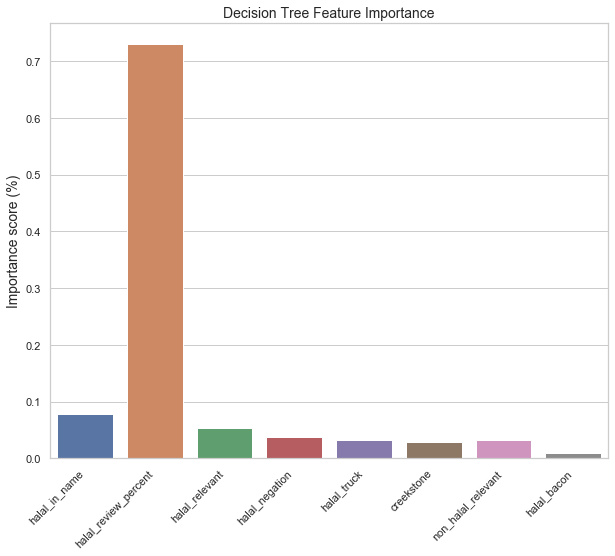

In [174]:
## Feature importance from Decision Tree
importances = model.feature_importances_
features = X.columns

# plot
plt.figure(figsize=(10,8))
g = sns.barplot(x=features, y=importances)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Decision Tree Feature Importance', size=14)
g.set_ylabel('Importance score (%)', size=14)
plt.show()

In [181]:
r = permutation_importance(model, X_train, y_train, n_repeats=3,)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<20} "
              f"{r.importances_mean[i]:.2f}"
              f" +/- {r.importances_std[i]:.2f}")

halal_review_percent 0.34 +/- 0.01
halal_relevant       0.17 +/- 0.00
non_halal_relevant   0.05 +/- 0.00
halal_truck          0.05 +/- 0.00
halal_in_name        0.05 +/- 0.00
halal_negation       0.03 +/- 0.00
creekstone           0.01 +/- 0.00
halal_bacon          0.00 +/- 0.00
